# EDA: 
1. копипаст публичного ноутбука с простыми статистиками и аггрегациями, но с добавлением "`персональныхN`" статистик-аггрегаций (где numgroupN=0) и 50 `GPT-фичей` глубины 0
2. предобработка тоже как в этом ноутбуке, дополнительно удаляю фичу если медиана уникальных значений по неделям < 5

# CV:
- с помощью этого сравнивал подходы (на что хватило времени...)
1. сначала `StratifiedShuffleSplit` (это как StratifiedKFold, но тут можно указать размер тестовой выборки) на 5 кусков (тест размера 0.1) с group=week_num для того чтобы было равномерное распределение данных по всем week_num
2. потом разбиваем разбитый train на train и val тем же StratifiedShuffleSplit с 1 куском. Все это нужно только чтобы сделать train, val, test в нужной пропорции stratified по weeks_num.

# модель:
- использую [`LightAutoML`](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb) только потому, что времени фитить LightGBM времени нет, а эта архитектура в базовой конфигурации добавляет фичи по типу простых разностей, обучает LGBM и catboost и фильтрует фичи с помощью importance, после чего оптюнит основные мета-параметры и блендит модели в соотношении их скора (в принципе то что я собирался делать руками, но быстрее)
- она дает результат на пару процентов лучше, чем lighgbm с подобранными параметрами из этого паблик-ноутбука


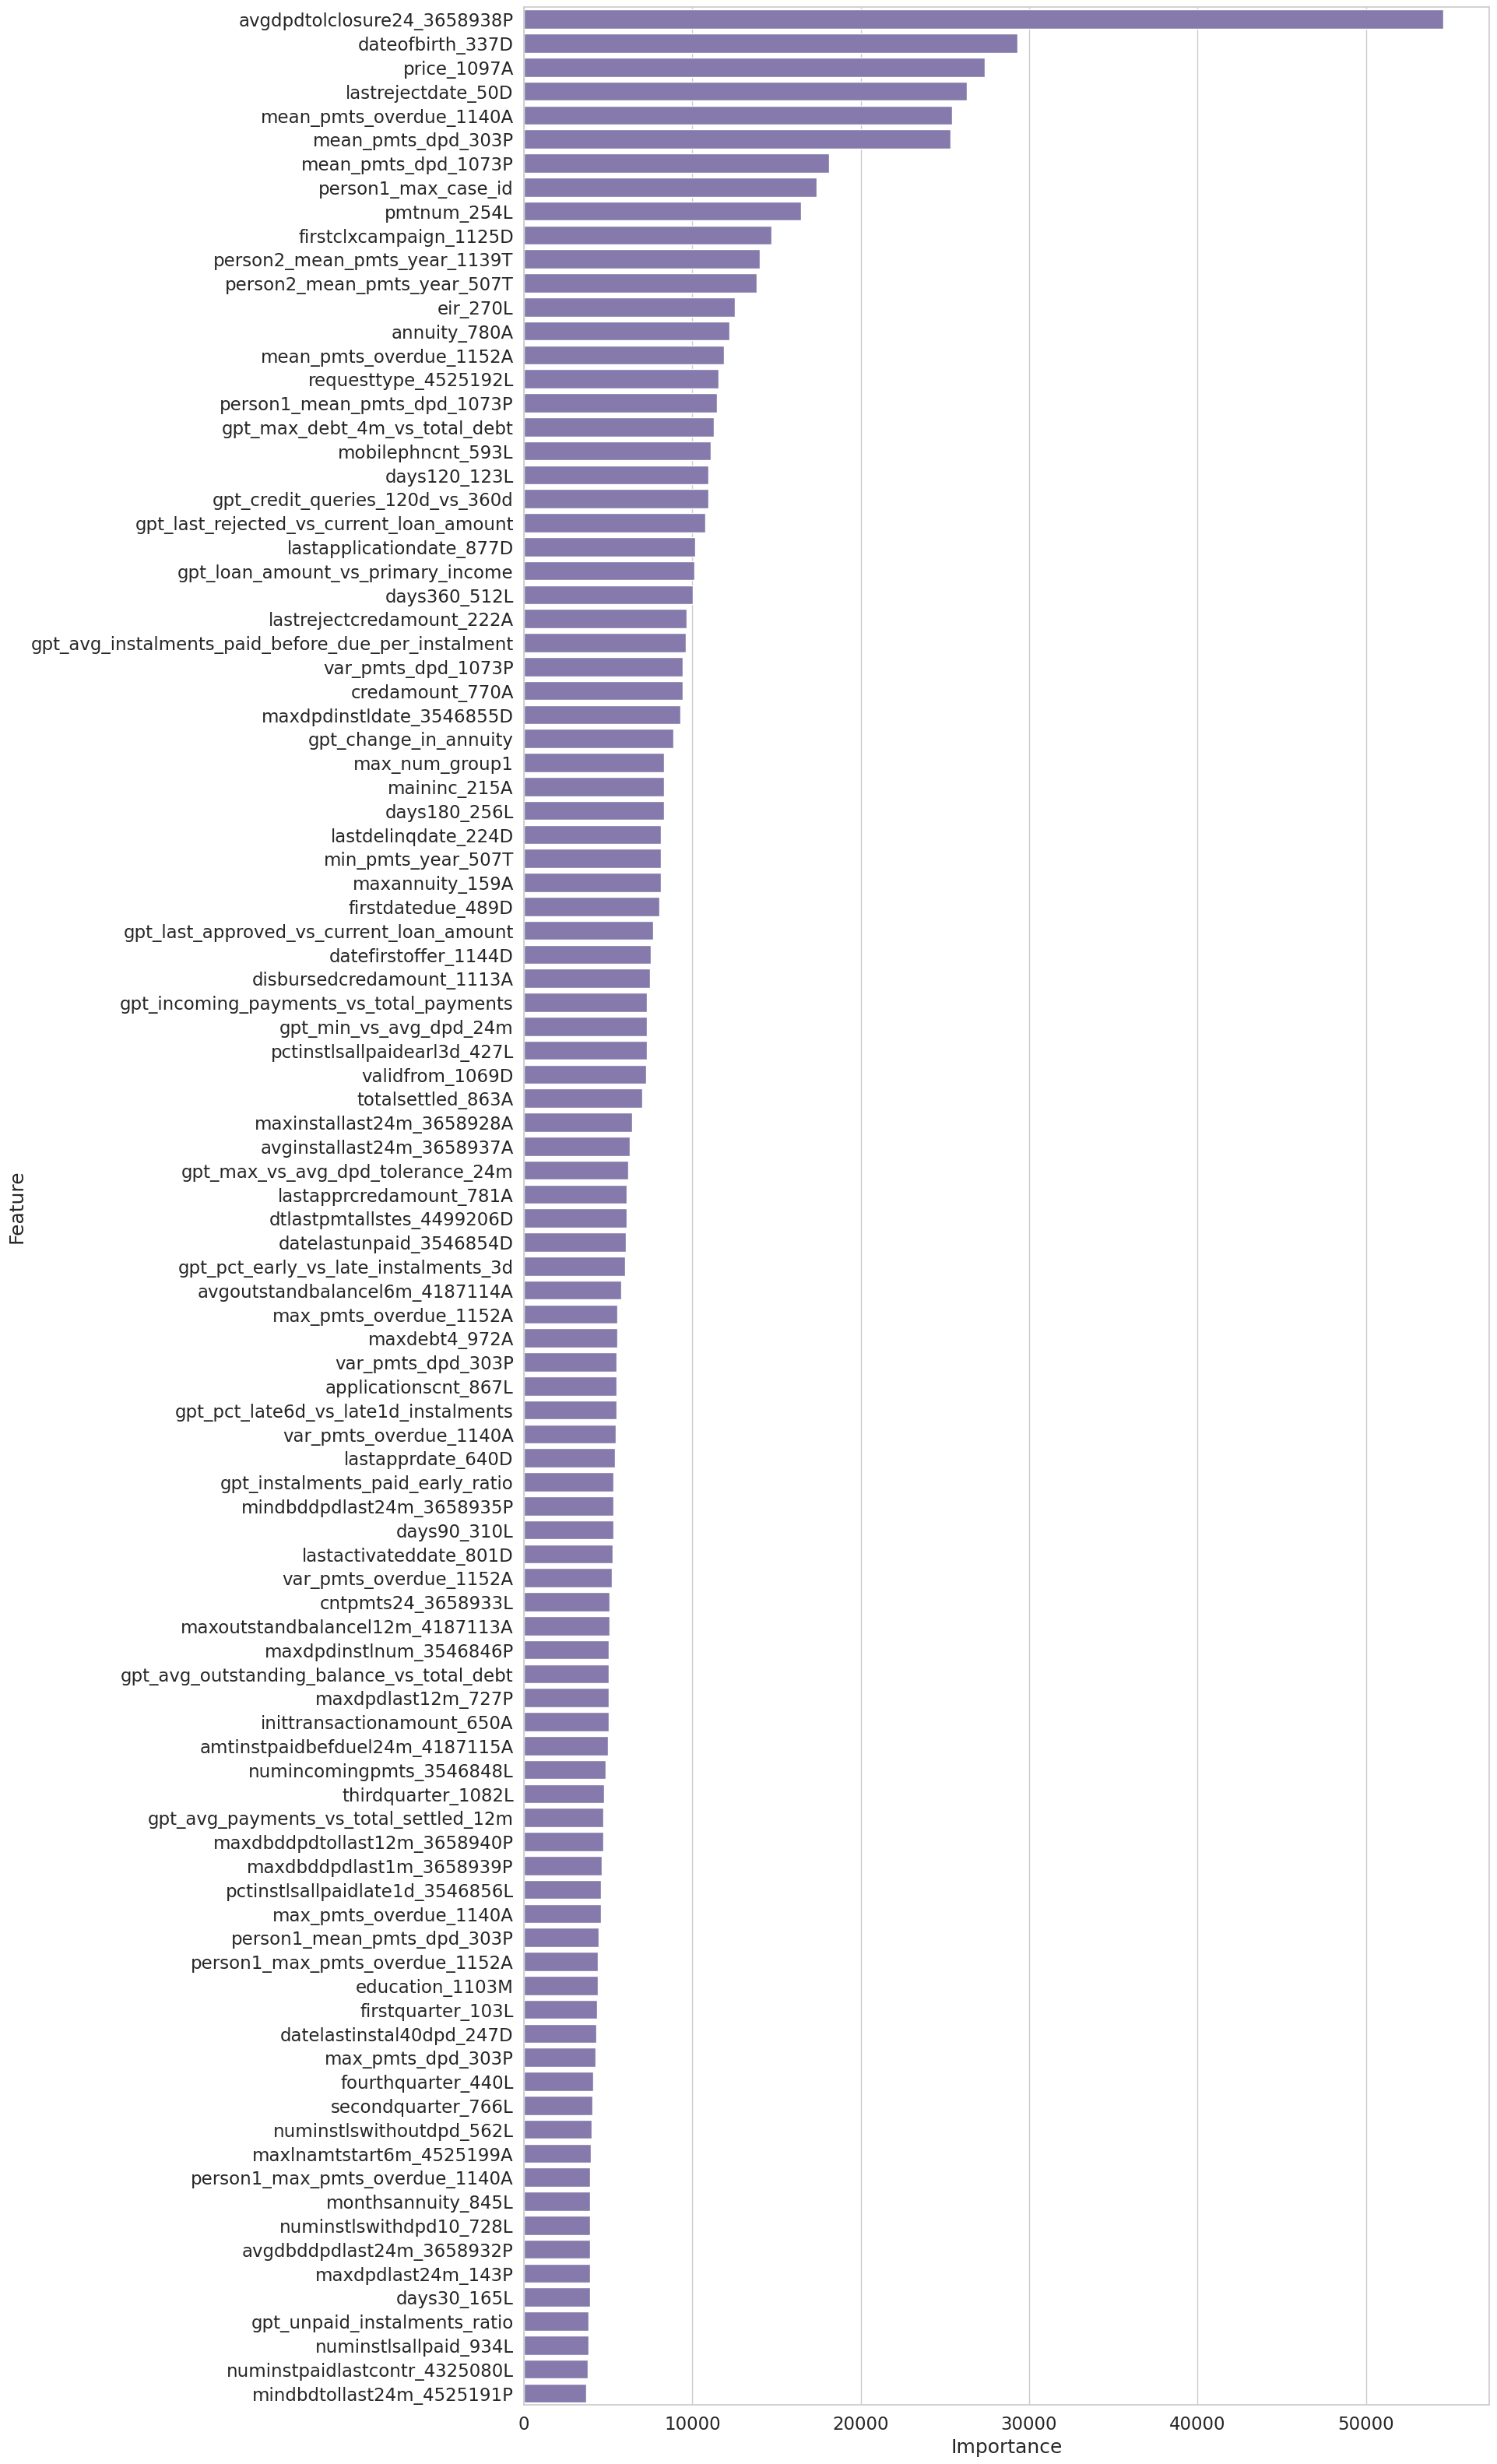

In [36]:
from IPython.display import Image
Image('feature_importance.png', width=1000)

In [13]:
# названия признаков после предобработки:
import pickle
num_cols, cat_cols = pickle.load(open('features_names.pkl', 'rb'))
spec_cols = ['case_id', 'month', 'week_num']
target_col = ['Target']
print(f'num_cols: {len(num_cols)}, cat_cols: {len(cat_cols)}')

num_cols: 220, cat_cols: 65


- `train_final.parquet` я загрузил в [публичный датасет](https://www.kaggle.com/datasets/philurame/home-risk-train)

In [18]:
import polars as pl
import pandas as pd
df = pl.read_parquet('train_final.parquet', low_memory=True, rechunk=True)
df = df.to_pandas().rename(columns={'target': 'Target'})[num_cols+cat_cols+spec_cols+target_col]
df.shape

(1526659, 289)

In [ ]:
%%capture
!pip install lightgbm=='3.2.1' 
!pip install pandas=='1.5.3'
!pip install -U lightautoml # будет загружаться минут 5

In [ ]:
from sklearn.metrics import roc_auc_score

automl = TabularAutoML(
      task = Task(name = 'binary', metric = roc_auc_score, greater_is_better=True),
      reader_params = {'cv': 10, 'random_state': 42},
      timeout = 5*3600, # 5 часов на всю работу
      cpu_limit = -1,
      memory_limit = 16 # 16Gb RAM
      )

oof_pred = automl.fit_predict(
    df[num_cols+cat_cols],
    roles = {'target': target_col[0], 'numeric': num_cols, 'category': cat_cols},
    verbose=3
    )

# остальное

- `дисбаланс`
- таргет дисбаланс 0.03 => пробовал применить стандартные аугментации `SMOTE, TomekLinks, RandomUnderSampler` после использования `StandardScaler`
- чтобы засунуть cat_cols сначала пытался использовать [`SMOTE-NC`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html), но оно использует knn => overhead, слишком большой df
- поэтому сделал `TargetEncoder` (см .py файл) на основе [`этого`](https://www.kaggle.com/code/ogrellier/python-target-encoding-for-categorical-features/notebook), после чего применил `SMOTE(0.1)` -> `TomekLinks` -> `RandomUnderSampler(0.3)` (это все еще работало вечность, но хотя бы конечное время)

$~$

- результат: на CV gini равномерно меньше, чем без аугментации :(. Можно потюнить minority переходы, но это слишком долго!

- - -

- `особенности признаков`
- примерно 1/3 признаков обладают "пропастью" нанов:

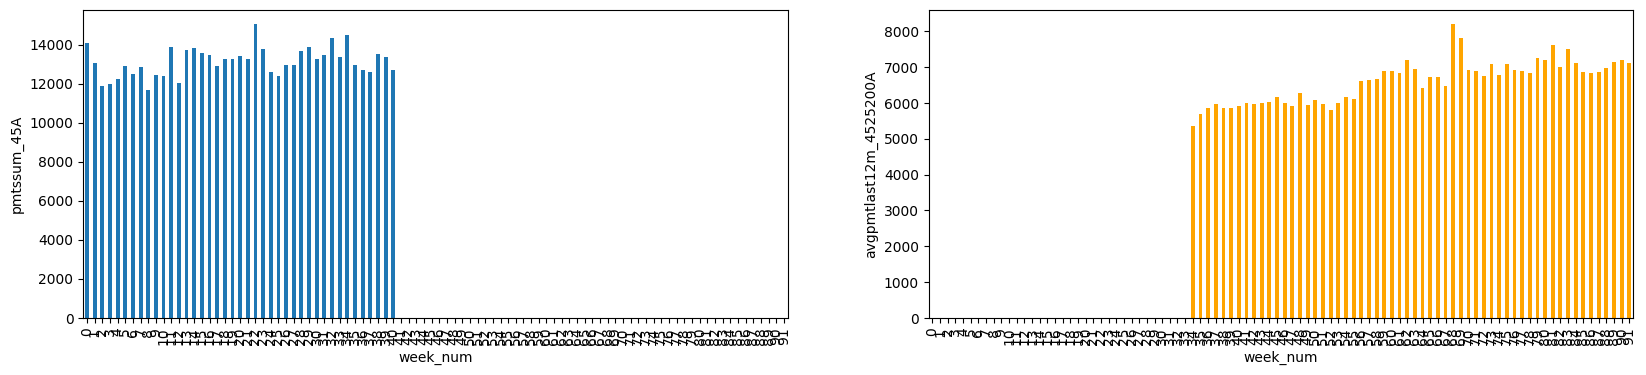

In [47]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
df.groupby('week_num')['pmtssum_45A'].mean().plot(kind='bar', ylabel='pmtssum_45A', ax=ax[0])
df.groupby('week_num')['avgpmtlast12m_4525200A'].mean().plot(kind='bar', ylabel='avgpmtlast12m_4525200A', ax=ax[1], color='orange');

- с помощью всяких cumsum и reversed-cumsum я достал статистики по "краям пропастей":

69 features with nans from left
21 features with nans from right


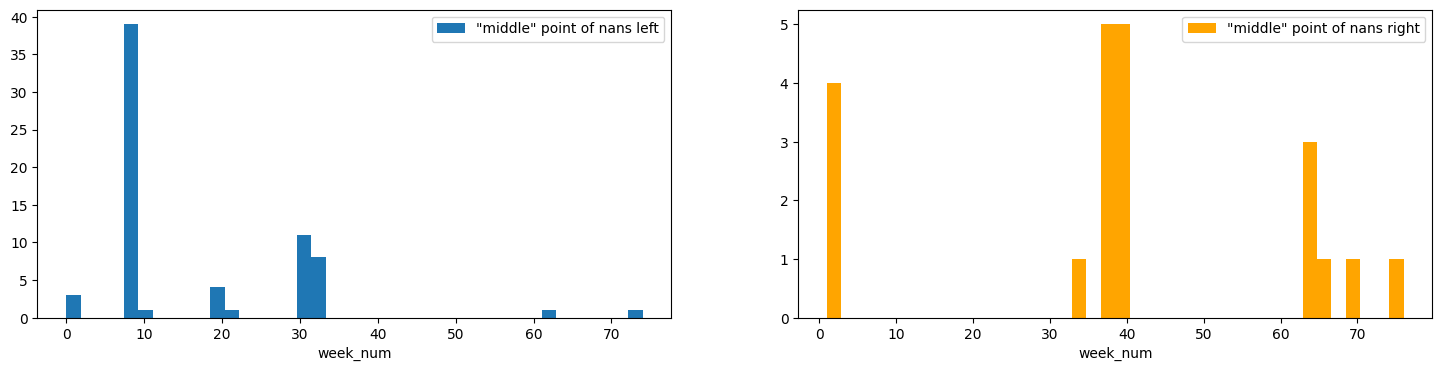

In [76]:
print(f'{sum((shares<0.1) & (islefts))} features with nans from left')
print(f'{sum((shares<0.1) & (~islefts))} features with nans from right')
fig, ax = plt.subplots(ncols=2, figsize=(18, 4))
ax[0].hist(argmaxes[(shares<0.1) & (islefts)], bins=40, label='"middle" point of nans left')
ax[0].legend(), ax[0].set_xlabel('week_num')
ax[1].hist(argmaxes[(shares<0.1) & (~islefts)], bins=40, label='"middle" point of nans right', color='orange')
ax[1].legend(), ax[1].set_xlabel('week_num');

- особо какой-то полезной информации я отсюда не вытащил, попробовал обучить модель без фичей с очень широкой пропастью (где на картинке nans left около 60-70 и nans right около 0), но получил примерно то же самое на CV

- - -

- распределение `target` по `week_num`

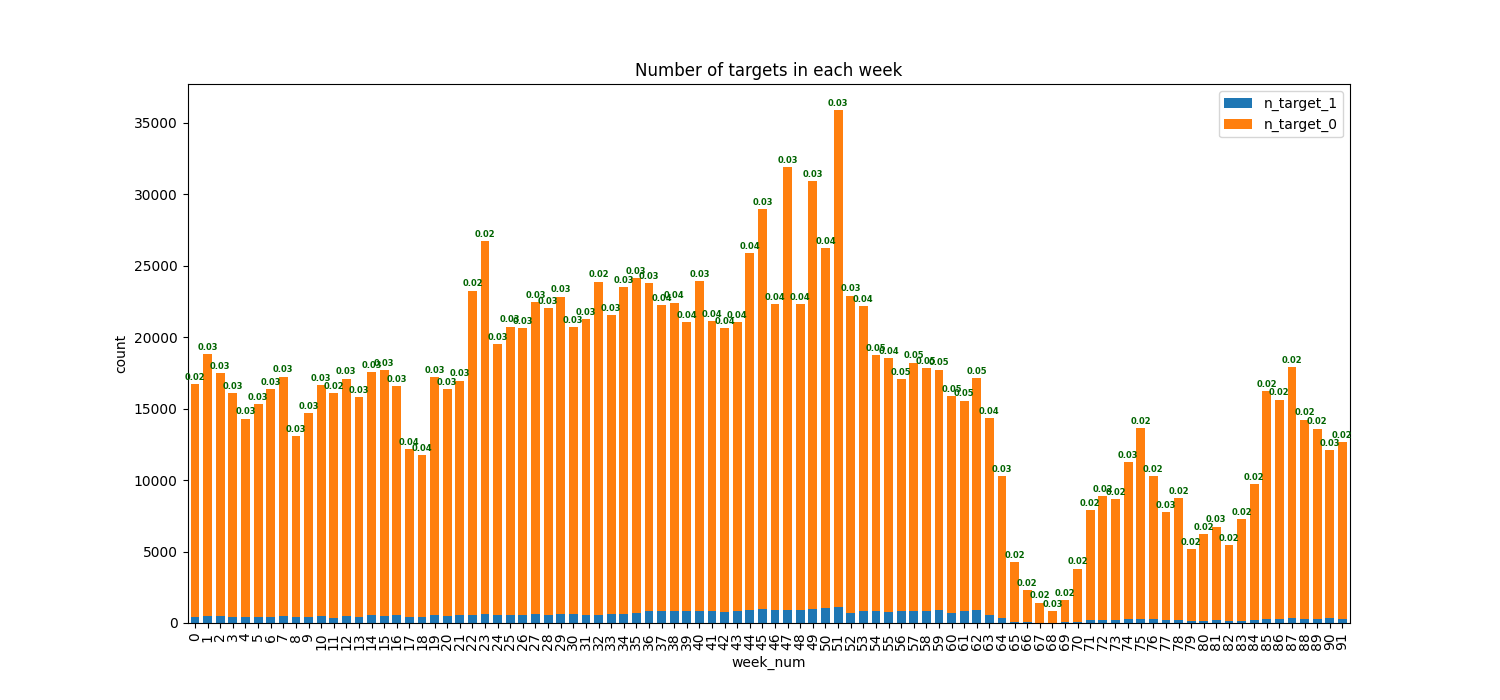

In [33]:
Image('target_week.png', width=1000)

1. COMPETITION HOST в одном из discussions написали, что тестовая выборка идет после train, захватывая немного часть с `covid`
2. многие в разделе discussion обсуждают тот факт, что нехватка данных и странное распределение в covid является главным источником наклона прямой метрики
- в связи с этим хочется проверить гипотезу, какая модель отработает лучше: та, что обучалась на всей выборке, или та, что не видела ковид? 
- будет ли результат эквивалентен выбрасыванию из выборки объекты, на которых модель слишком плохо предсказала вероятность?
- на CV такая проверка не особо сработает из-за отсутствия тестовых данных, поэтому надеюсь успеть это проверить на public LB

In [6]:
df_covid = df.query('week_num>64 and week_num<72')
df = df.query('week_num<=64 or week_num>=72')

- - -

- `взлом метрики`
- все время потратил на аугментацию и фичи, на модель с предсказанием week_num времени не осталось. Мне кажется, это не очень простая задача тк данные судя по скорам на CV довольно равномерно распределены, не считая `covid` периода, который и можно было бы поэксплуатировать
- в любом случае ввиду отсутствия информации о распределении дат в тесте это все может не сработать
- поэтому логично в одном (из 2) submission занизить вероятности у лучших скоров, чтобы выровнять прямую метрики (как везде это постят)